# HiClass baseline name and description

In [57]:
import os
os.chdir("/home/app/src")

In [144]:
import time
import pandas as pd
import numpy as np
import text_normalizer
import hiclass.metrics
from sklearn import metrics
from scripts.build_df import build_df
from scripts.decode_id import decode_id
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from os import cpu_count
from hiclass import LocalClassifierPerNode, LocalClassifierPerParentNode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
import pickle

In [59]:
no_threshold_df = build_df(json_path='data/products.json', threshold=0) 

In [60]:
def normalization(input):
    output = text_normalizer.normalize_corpus(
        input,
        html_stripping=True,
        contraction_expansion=True,
        accented_char_removal=True,
        text_lower_case=True,
        text_stemming=True,
        text_lemmatization=False,
        special_char_removal=True,
        remove_digits=False,
        stopword_removal=True,
        stopwords=text_normalizer.stopword_list
    )       
    return output

In [61]:
y = no_threshold_df['path'].copy()

name = no_threshold_df["name"].copy()
name = normalization(name.apply(str))
name_train, name_test, y_train, y_test = train_test_split(
    name, y,
    test_size=0.20, 
    random_state=42,
)

description = no_threshold_df["description"].copy()
description = normalization(description.apply(str))
description_train, description_test, y_train, y_test = train_test_split(
    description, y,
    test_size=0.20, 
    random_state=42,
)

In [62]:
tfid_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
name_train = tfid_vectorizer.fit_transform(name_train)
name_test = tfid_vectorizer.transform(name_test)

# tfid_vectorizer = TfidfVectorizer(ngram_range=(1,2))
description_train = tfid_vectorizer.transform(description_train) 
description_test = tfid_vectorizer.transform(description_test)

X_train = hstack((name_train, description_train))
X_test = hstack((name_test, description_test))

### Hierarchical classification

In [123]:
init_timer = time.time()
# Initialize model
random_forest = RandomForestClassifier(n_estimators = 500, n_jobs=cpu_count(), random_state=42)
# Initialize hierarchical classifier with model
hierarchical_classifier = hiclass.LocalClassifierPerNode(binary_policy="exclusive", n_jobs=cpu_count(), local_classifier=random_forest)
# Train hierarchical classifier
hierarchical_classifier.fit(X_train, y_train)
# Training time
training_time = time.time() - init_timer
training_time = time.strftime("%H:%M:%S", time.gmtime(training_time))

# Predict on train and test
y_pred_train = hierarchical_classifier.predict(X_train)
y_pred_test = hierarchical_classifier.predict(X_test)

In [124]:
# Print standard results
print("Train")
print("Precision:", hiclass.metrics.precision(y_train, y_pred_train))
print("Recall:", hiclass.metrics.recall(y_train, y_pred_train))
print("F1:", hiclass.metrics.f1(y_train, y_pred_train))
print("\nTest")
print("Precision:", hiclass.metrics.precision(y_test, y_pred_test))
print("Recall:", hiclass.metrics.recall(y_test, y_pred_test))
print("F1:", hiclass.metrics.f1(y_test, y_pred_test), "\n")
print("Training time:", training_time)

Train
Precision: 0.9341965570919607
Recall: 0.9990666183722939
F1: 0.965543240086571

Test
Precision: 0.844249346075156
Recall: 0.9023445068785119
F1: 0.8723307465881723 

Training time: 02:29:31


In [ ]:
filename = "notebooks/hierarchical_classification/saved_models/exclusive_name_description_500.sav"
pickle.dump(hierarchical_classifier, open(filename, "wb"))

In [125]:
# Random coso 300

# Train
# Precision: 0.9349817148295666
# Recall: 0.9990596528377588
# F1: 0.9659591806497019

# Test
# Precision: 0.8297075423293997
# Recall: 0.8952307138705123
# F1: 0.8612246528286311 

# Total failures: 505 of 10330
# Training time: 00:06:38


#######################

# Exclusive - 100

# Train
# Precision: 0.9341965570919607
# Recall: 0.9990666183722939
# F1: 0.965543240086571

# Test
# Precision: 0.844249346075156
# Recall: 0.9023445068785119
# F1: 0.8723307465881723 

# Total failures: 348 of 10330
# Training time: 02:29:31

### Analyze predictions

In [126]:
# Base DataFrame
test_df = pd.DataFrame(y_test)
# Add prediction column respecting original index
test_df["prediction"] = pd.Series(y_pred_test.tolist(), index = test_df.index)

# Auxiliary function for creating new columns
def assign_precision(x):
    return hiclass.metrics.precision(x[0:1], x[1:2])
def assign_recall(x):
    return hiclass.metrics.recall(x[0:1], x[1:2])
def assign_f1(x):
    # Condition to avoid ZeroDivisionError
    if x["precision"] * x["recall"] == 0.0:
        return 0.0
    else:
        return 2 * x["precision"] * x["recall"] / (x["precision"] + x["recall"])

# Creat new metrics columns 
test_df["precision"] = test_df.apply(lambda x: assign_precision(x), axis=1)
test_df["recall"] = test_df.apply(lambda x: assign_recall(x), axis=1)
test_df["f1"] = test_df.apply(lambda x: assign_f1(x), axis=1)

In [127]:
test_df.head()

,path,prediction,precision,recall,f1
13005,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[pcmcat312300050015, pcmcat248700050021, pcmca...",1.00,1.00,1.00
36568,"[abcat0207000, pcmcat152100050020, pcmcat20570...","[abcat0207000, pcmcat152100050035, pcmcat25160...",0.25,0.25,0.25
20664,"[abcat0500000, pcmcat209000050006, pcmcat20900...","[abcat0500000, pcmcat209000050006, pcmcat20900...",1.00,1.00,1.00
40271,"[abcat0900000, abcat0912000, pcmcat36740005000...","[abcat0900000, abcat0912000, pcmcat36740005000...",1.00,1.00,1.00
5865,"[abcat0300000, pcmcat165900050023, pcmcat33160...","[abcat0300000, pcmcat165900050023, pcmcat33160...",1.00,1.00,1.00


In [128]:
print("Total failures:", len(test_df["f1"][test_df["f1"] == 0.0]), "of", len(test_df))
test_df["f1"][test_df["f1"] == 0.0]

Total failures: 348 of 10330


13167    0.0
49777    0.0
11541    0.0
49286    0.0
47022    0.0
        ... 
22456    0.0
30674    0.0
28953    0.0
31535    0.0
24334    0.0
Name: f1, Length: 348, dtype: float64

In [129]:
def print_path_metrics(index, df_):
    print("Product name:", no_threshold_df["name"].loc[index])
    print(f"Product description:\n{no_threshold_df['description'].loc[index]}\n")
    print("Original path:", decode_id(no_threshold_df["path"].loc[index]))
    print("Threshold path:", decode_id(df_["path"].loc[index]))
    print("Predicted path:", decode_id(df_["prediction"].loc[index]))
    print("\nMetrics (on threshold and predicted path)")
    print("Precision:", df_["precision"].loc[index])
    print("Recall:", df_["recall"].loc[index])
    print("F1:", df_["f1"].loc[index])

### Correct prediction

In [143]:
print_path_metrics(36568, test_df)

Product name: RODE - Microphone Shock Mount - Black
Product description:
Compatible with most RODE large-diaphragm microphones; detachable pop filter; 2 axes of adjustment; telescopic arm

Original path: ['Musical Instruments', 'Recording Equipment', 'Recording Furniture & Stands', 'Recording & Music Stands']
Threshold path: ['Musical Instruments', 'Recording Equipment', 'Recording Furniture & Stands', 'Recording & Music Stands']
Predicted path: ['Musical Instruments', 'Microphones & Live Sound', 'Microphones & Accessories', 'Microphone Accessories', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.25
Recall: 0.25
F1: 0.25


### Kind of correct prediction

In [131]:
print_path_metrics(47899, test_df)

Product name: MartinLogan - Dynamo 15" 650W Powered Subwoofer - Gloss Black
Product description:
1300W peak power; 15" high-excursion polypropylene woofer cone in cast-aluminum basket; ceramic magnet; adjustable front- or down-firing configuration; L/R LFE RCA line-level, LFE XLR and 12V trigger inputs

Original path: ['Audio', 'Home Audio', 'Speakers', 'Subwoofer Speakers']
Threshold path: ['Audio', 'Home Audio', 'Speakers', 'Subwoofer Speakers']
Predicted path: ['Audio', 'Home Audio', 'Speakers', 'Subwoofer Speakers', '', '', '']

Metrics (on threshold and predicted path)
Precision: 1.0
Recall: 1.0
F1: 1.0


In [132]:
print_path_metrics(4702, test_df)

Product name: Elite Cuisine - 2-in-1 Dual-Function Breakfast Station
Product description:
2-slice toaster with 7-shade variable browning control, cancel/stop button and slide-out crumb tray; single-serve coffeemaker with removable, washable filter; cool-touch body; antislip rubber feet

Original path: ['Appliances', 'Small Kitchen Appliances', 'Toasters']
Threshold path: ['Appliances', 'Small Kitchen Appliances', 'Toasters']
Predicted path: ['Appliances', 'Small Kitchen Appliances', 'Coffee, Tea & Espresso', 'Coffee Makers', 'Multi-Cup Coffee Makers', '', '']

Metrics (on threshold and predicted path)
Precision: 0.4
Recall: 0.6666666666666666
F1: 0.5


### Complete failures 

In [133]:
print("Total failures:", len(test_df["f1"][test_df["f1"] == 0.0]), "of", len(test_df))
test_df["f1"][test_df["f1"] == 0.0]

Total failures: 348 of 10330


13167    0.0
49777    0.0
11541    0.0
49286    0.0
47022    0.0
        ... 
22456    0.0
30674    0.0
28953    0.0
31535    0.0
24334    0.0
Name: f1, Length: 348, dtype: float64

#### Failures (?)

In [134]:
print_path_metrics(49777, test_df)

Product name: Apple - Optical Mouse - White
Product description:
Force-sensing side buttons; scroll ball; optical technology; touch-sensitive top shell

Original path: ['Name Brands', 'Apple', 'Accessories']
Threshold path: ['Name Brands', 'Apple', 'Accessories']
Predicted path: ['Computers & Tablets', 'Computer Accessories & Peripherals', 'Mice & Keyboards', 'Mice', 'Wireless & Bluetooth Mice', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [135]:
print_path_metrics(11541, test_df)

Product name: Serta - RTA Santa Cruz Collection 61" Fabric Loveseat Sofa - Beige
Product description:
SERTA RTA Santa Cruz Collection 61" Fabric Loveseat Sofa: Hardwood frame with polyester fabric upholstery; accommodates 2 people; rich espresso finish on the wood and plastic footers; includes 2 accent pillows

Original path: ['Magnolia Home Theater', 'Magnolia Accessories', 'Magnolia TV Stands, Mounts & Furniture']
Threshold path: ['Magnolia Home Theater', 'Magnolia Accessories', 'Magnolia TV Stands, Mounts & Furniture']
Predicted path: ['Connected Home & Housewares', 'Furniture & Decor', 'Living Room Furniture', 'Sofas & Sectionals', 'Sofas', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [136]:
print_path_metrics(31535, test_df)

Product name: JOBY - GripTight GorillaPod Magnetic XL Tripod for Select Cell Phones
Product description:
Compatible with most cell phones; magnetic feet; flexible legs

Original path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Tripods & Monopods', 'Camera Mounts']
Threshold path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Tripods & Monopods', 'Camera Mounts']
Predicted path: ['Cell Phones', 'Cell Phone Accessories', 'Cell Phone Cases & Clips', 'Fitted', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


#### Failures

In [137]:
print_path_metrics(13167, test_df)

Product name: FLIR - Sport Case and Mount for FLIR FX Cameras - Transparent
Product description:
FLIR Sport Case and Mount for FLIR FX Cameras: Compatible with most FLIR FX cameras; works with most 1/4"-20 mounting devices; waterproof

Original path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera & System Accessories', 'Surveillance Camera Mounts']
Threshold path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera & System Accessories', 'Surveillance Camera Mounts']
Predicted path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Tripods & Monopods', 'Monopods', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [138]:
print_path_metrics(24334, test_df)

Product name: SteelSeries - Siberia Prism 150 Gaming Headset - Black
Product description:
SteelSeries Engine 3 technology; ColorShift technology; integrated volume control; chat capability

Original path: ['Name Brands', 'SteelSeries', 'SteelSeries Headsets']
Threshold path: ['Name Brands', 'SteelSeries', 'SteelSeries Headsets']
Predicted path: ['Video Games', 'Xbox One', 'Xbox One Accessories', 'Xbox One Headsets', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [139]:
print_path_metrics(13167, test_df)

Product name: FLIR - Sport Case and Mount for FLIR FX Cameras - Transparent
Product description:
FLIR Sport Case and Mount for FLIR FX Cameras: Compatible with most FLIR FX cameras; works with most 1/4"-20 mounting devices; waterproof

Original path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera & System Accessories', 'Surveillance Camera Mounts']
Threshold path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera & System Accessories', 'Surveillance Camera Mounts']
Predicted path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Tripods & Monopods', 'Monopods', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [140]:
print_path_metrics(51294, test_df)

Product name: Lenmar - Notebook Battery - Black
Product description:
Proprietary2200mAh - 11.1V DC

Original path: ['Computers & Tablets', 'Computer Accessories & Peripherals', 'Laptop Accessories', 'Laptop Batteries']
Threshold path: ['Computers & Tablets', 'Computer Accessories & Peripherals', 'Laptop Accessories', 'Laptop Batteries']
Predicted path: ['Computers & Tablets', 'Computer Accessories & Peripherals', 'Laptop Accessories', 'Laptop Batteries', '', '', '']

Metrics (on threshold and predicted path)
Precision: 1.0
Recall: 1.0
F1: 1.0


#### Plots

<AxesSubplot:xlabel='f1', ylabel='Percent'>

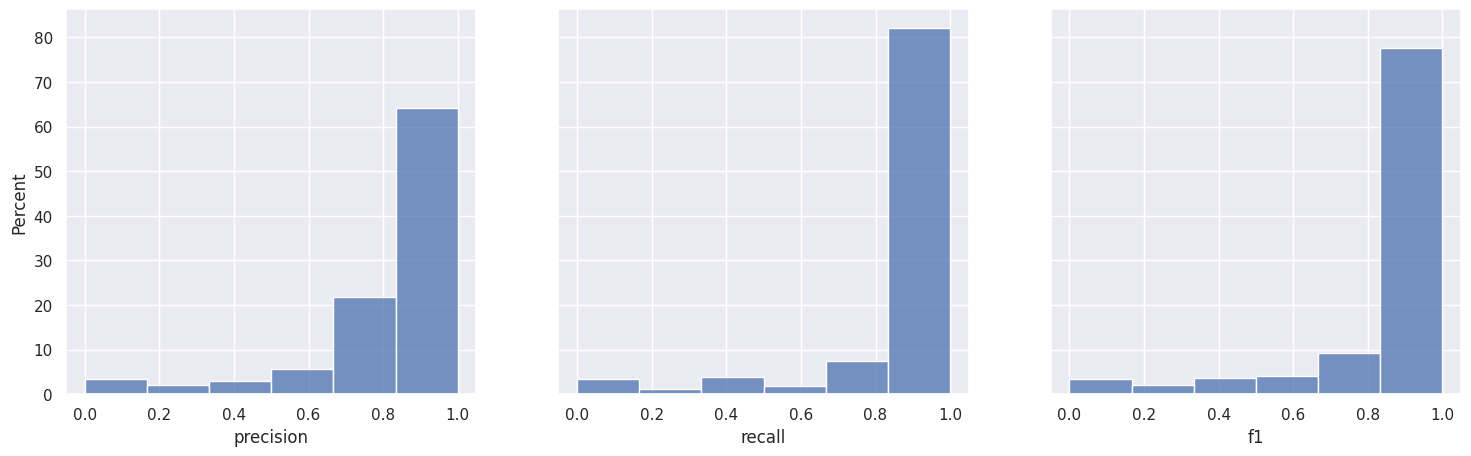

In [141]:
sns.set()
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)
sns.histplot(test_df["precision"], stat="percent", ax=axes[0], bins=6)
sns.histplot(test_df["recall"], stat="percent",ax=axes[1], bins=6)
sns.histplot(test_df["f1"], stat="percent",ax=axes[2], bins=6)

#### Predict on new data

In [145]:
filename = "notebooks/hierarchical_classification/saved_models/exclusive_name_description_500.sav"
pickle.dump(hierarchical_classifier, open(filename, "wb"))

In [142]:
string_to_predict = "2-slice toaster with 7-shade variable browning control, cancel/stop button and slide-out crumb tray; single-serve coffeemaker with removable, washable filter; cool-touch body; antislip rubber feet"
decode_id(hierarchical_classifier.predict(tfid_vectorizer.transform(normalization(pd.Series(string_to_predict)))).tolist()[0])

ValueError: X has 18596 features, but RandomForestClassifier is expecting 37192 features as input.